In [1]:
from bs4 import BeautifulSoup
import urllib, urllib2
import requests
import re
import pandas as pd
from tqdm import tqdm_notebook
itinera = pd.DataFrame(columns = [['texts', 'date']])
collection = []
year = []

In [3]:
def read_iter(url):
    content = urllib2.urlopen(url).read()
    soup = BeautifulSoup(content, "html.parser")
    for transcr in soup.find_all('div',attrs={"id" : "context-label"}):
        nummer = "".join(transcr.text)
        nummer = nummer[:-1]
        nummer = int(nummer.split()[-1])
    for i in tqdm_notebook(range(nummer), desc = "one file"):
        all_div = soup.find_all('div')
        d = 0
        for element in all_div:
            if "Datum" in element:
                d = 1
                date = "".join(element.text)
                date = date.split()
                if isinstance(date[1], unicode):         #check whether there is actually a date in the file
                    year.append(date[1])
                else:
                    year.append("No date")                                  # else append 'no date' --> no empty cells
        if d != 1:                                       # check whether there is a div with 'datum' as text because if not, it will skip it
                year.append("No date")                   # and no 'No date' will be added --> inequal amount of indexes in dataframe = error
        for transcr in soup.find_all('div',attrs={"class" : "transcription"}):
            final = (transcr.text).encode('utf-8')
            collection.append(final)

        for link in soup.findAll('a', text = "Volgende"):
            new_link = link.get('href')
            url = "http://www.itineranova.be" + new_link
            new_url = urllib.quote(url.encode('utf8'), ':/')
        content = urllib2.urlopen(new_url).read()
        soup = BeautifulSoup(content, "html.parser")


In [4]:
no_trans = []                                                     # ook: uitsluiting van eerste twee documenten --> eerste leeg en tweede foute url voor tekst 9 --> zorgde voor problemen met data
for n in tqdm_notebook(range(7326-7303), desc = "all files"):     # voorlopig enkel tot en met 1430 door processing time
                                                                  # voor alle documenten van eerste kamer: gebruik 7704 ipv 7326 --> SAL nummer van itinera + 1
    doc = 7303 + n
    #     if content = urllib2.urlopen("http://www.itineranova.be/in/SAL"+str(doc)+"/*/transcription").read() != 
    try:
        read_iter("http://www.itineranova.be/in/SAL"+str(doc)+"/*/transcription")
    except urllib2.HTTPError as err:
        no_trans.append(err.code)
        if err.code == 400:
            continue
    if len(collection) != len(year):
        while len(collection) - len(year) > 0:
            year.append("No date motherf***")          # er is ergens in fout in de datum, rond het 9e document vanaf 7303
                                                   # niet door geen div met datum, noch door twee divs met datum --> daarom appenden van geen datum om index juist te krijgen
                                                   # maar zeker nog eens nakijken wat er precies mis is!!!

In [45]:
itinera = pd.DataFrame(columns = [['texts', 'date']])
itinera['texts'] = collection
itinera['date'] = year
print itinera.shape
itinera.head()


#error met dataframe --> uitzoeken hoe je nieuwe waarden achter de oude plakt in dataframe

(1722, 2)


,texts,date
0,It(em) de meye(r) va(n) loven(en) metde(n) sce...,1400-08-15
1,It(em) wout(er) eveloghe es come(n) voe(r) [me...,1400-08-15
2,It(em) henr(ic) m(er)te en(de) joffr(ouwe) mag...,1400-08-15
3,It(em) joh(annes) van boshoele heeft machtich ...,1400-09-24
4,It(em) vanden gedinghe dat gheweest heeft tuss...,1400-09-30


### Text processing

Get the "/" and "(" and ")" out. I realise it is not very good in terms of transcription, but it will mess up any text analysis and more important it makes it hard to store it into a csv-file or text-file since it recognises it as separations. Possibly also for "[]".

In [46]:
ind = 0
for t in tqdm_notebook(itinera['texts']):
    new = t.replace("(", "")
    new = new.replace(")", "")
    new = new.replace("/", "")
    itinera.loc[ind][0] = new
    ind += 1

In [56]:
itinera.head()

,texts,date
0,Item de meyer van lovenen metden scepenen van ...,1400-08-15
1,Item wouter eveloghe es comen voer [meyer ende...,1400-08-15
2,Item henric merte ende joffrouwe magriete sijn...,1400-08-15
3,Item johannes van boshoele heeft machtich gema...,1400-09-24
4,Item vanden gedinghe dat gheweest heeft tussch...,1400-09-30


In [51]:
no_date = []
for nd in itinera['date']:
    if 'date' in nd:
        no_date.append(nd)
print len(no_date)

321


### save data in csv

In [68]:
itinera.to_csv('itinera_first.csv', sep='\t', encoding='utf-8', index=False)

In [2]:
new_itinera = pd.DataFrame()
new_itinera = pd.read_csv('itinera_first.csv', sep='\t')
new_itinera.head()

,texts,date
0,Item de meyer van lovenen metden scepenen van ...,1400-08-15
1,Item wouter eveloghe es comen voer [meyer ende...,1400-08-15
2,Item henric merte ende joffrouwe magriete sijn...,1400-08-15
3,Item johannes van boshoele heeft machtich gema...,1400-09-24
4,Item vanden gedinghe dat gheweest heeft tussch...,1400-09-30


Splitting the dataframe in test and train. Train being the ones with a clear year, test the ones without.
Also some more date processing: put the ones with "-" or "?" in year in the dataframe with no dates.

In [9]:
train = pd.DataFrame(columns = [['texts', 'date']])
test = pd.DataFrame(columns = [['texts', 'date']])
test_date = []
train_date = []
test_text = []
train_text = []
ind = 0
for nd in new_itinera['date']:
#     if nd[2] == "-":
#         print nd
    if 'date' in nd or nd[2] == "-" or nd[2] == "?":
        test_date.append(new_itinera['date'][ind])
        test_text.append(new_itinera['texts'][ind])
    else:
        train_date.append(new_itinera['date'][ind])
        train_text.append(new_itinera['texts'][ind])
    ind += 1

In [10]:
train['texts'] = train_text
train['date'] = train_date
test['texts'] = test_text
test['date'] = test_date

In [14]:
print test.head()
print test.shape
print train.head()
print train.shape

                                               texts        date
0                            Item de selve jan fyen      No date
1  Cont ende kenlec sij allen lieden dat van alsu...     No date
2  Item wouter mons ende gheert hermans scepenen ...  14??-03-28
3  Item lambrecht stael et henric bierboc in deen...     No date
4  jan weeghbroet heeft dese brieve [ontfaen] te ...        14--
(323, 2)
                                               texts        date  realDate
0  Item de meyer van lovenen metden scepenen van ...  1400-08-15      1400
1  Item wouter eveloghe es comen voer [meyer ende...  1400-08-15      1400
2  Item henric merte ende joffrouwe magriete sijn...  1400-08-15      1400
3  Item johannes van boshoele heeft machtich gema...  1400-09-24      1400
4  Item vanden gedinghe dat gheweest heeft tussch...  1400-09-30      1400
(1399, 3)


Convert the train dates to integers --> only the years!! They will serve as the target class.

In [12]:
real = []
for jd in train['date']:
    real.append(int(jd[:4]))
train['realDate'] = real

### feature selection

In [15]:
features = pd.DataFrame()
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train['texts'])
X_train_counts.shape
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=False).fit(X_train_counts)
X_train_tfidf = transformer.transform(X_train_counts)
features['tfidf'] = list(X_train_tfidf.toarray())
features.head()

,tfidf
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [22]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from time import time
from sklearn.grid_search import GridSearchCV
from operator import itemgetter
import scipy as sp
from scipy.stats import t
from scipy import stats
from sklearn.cross_validation import cross_val_score

In [16]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return "95% confidence interval: "  + str((m-h, m+h))

In [24]:
from sklearn.dummy import DummyClassifier
def dumClass(feature_set):
    classifier = DummyClassifier()
#     x_train, x_test  = train_test_split(feature_set, test_size = 0.33, random_state=42)
#     y_train, y_test = train_test_split(train['realDate'], test_size = 0.33, random_state=42)
#     t0 = time()
#     classifier.fit(x_train, y_train)
#     print 'training time: ', round(time()-t0, 3), 's'
#     print
    t1 = time()
    accuracies = cross_val_score(classifier, feature_set, train['realDate'], cv=10) #volledige data gebruiken want split automatisch!!!!!
    print 'predicting time: ', round(time()-t1, 3), 's'
    print
    for acc in accuracies:
        print acc
    print
    print np.mean(accuracies)
    print
    print mean_confidence_interval(accuracies)
    print
    

#     y_pred = classifier.fit(x_train, y_train).predict(x_test)
    
#     conf = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
#     print conf
#     im = plt.imshow(conf.iloc[0:3, 0:3], cmap='binary', interpolation='None')
#     plt.xticks([0, 1, 2], ['course', 'faculty', 'student'])
#     plt.yticks([0, 1, 2], ['course', 'faculty', 'student'])
#     plt.show(im)
#     return accuracies, conf, im
print "Dummy accuracy: "
print
dumClass(features['tfidf'].tolist())

 Dummy accuracy: 

predicting time:  0.413 s

0.031847133758
0.0526315789474
0.0342465753425
0.0413793103448
0.0652173913043
0.0735294117647
0.0441176470588
0.0225563909774
0.0769230769231
0.031746031746

0.0474194548167

95% confidence interval: (0.033881407110998123, 0.060957502522412478)



In [61]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

     
X = X_train_tfidf.todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=train['realDate'])
plt.colorbar()


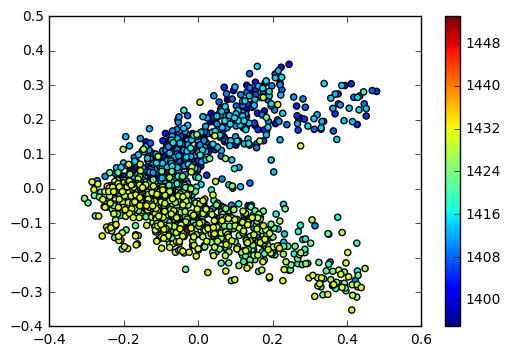

In [62]:
plt.show()

In [53]:
feature_array = np.array(X_train_tfidf.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]

AttributeError: get_feature_names not found

In [40]:
from sklearn.svm import SVC

def logReg(feature_set):
    classifier = SVC()
    t1 = time()
    accuracies = cross_val_score(classifier, feature_set, train['realDate'], cv=10)
    print 'predicting time: ', round(time()-t1, 3), 's'
    print
    for acc in accuracies:
        print acc
    print
    print np.mean(accuracies)
    print
    print mean_confidence_interval(accuracies)
    print
print "Knn: "
print
logReg(features['tfidf'].tolist())

Knn: 

predicting time:  1275.755 s

0.0764331210191
0.0789473684211
0.0821917808219
0.0827586206897
0.0869565217391
0.0882352941176
0.0882352941176
0.0902255639098
0.0923076923077
0.0952380952381

0.0861529352382

95% confidence interval: (0.081887818982561783, 0.09041805149378232)

